In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from flatsurf import *
import numpy as np
from matplotlib import pyplot as plt
import os
import pwlf
import sympy as sym
from sympy import Symbol
from sympy import solve, lambdify
import os
from Poincare import *
from Poincare import Section
import math
from surface_dynamics.all import *
from time import time

In [3]:
#Code from Sunrose 
#Gives non-visibility tori for testing
D = OrigamiDatabase()
q = D.query()
qlist = q.list()

def unit_hor_saddle(O):
    count = 0
    for vert in O.vertices():
        tup = vert.up_right_tuple()
        for i in tup:
            for vert2 in O.vertices():
                tup2 = vert2.up_right_tuple()
                if O.r()(i) in tup2:
                    return True
    return False

def is_unobstructed(O):
    cusp_reps = O.teichmueller_curve().cusp_representatives()
    for item in cusp_reps:
        if not unit_hor_saddle(item[0]):
            return False
    return True

def obstructed(n, **kwargs):
    obstructed = []
    count_obstructed = 0
    p = D.query(nb_squares=n, **kwargs)
    for item in p:
        if not is_unobstructed(item):
            obstructed.append(item)
            count_obstructed+= item.teichmueller_curve().orbit_graph().num_verts()
    return (obstructed, count_obstructed)

In [4]:
# generate vectors for saddle connections on STS
def vectors(perm, length = 200):
    a = str(perm)
    h, v = a.split("\n")
    S = SymmetricGroup(len(h))
    T = translation_surfaces.origami(S(h), S(v))
    T = T.erase_marked_points()
    sc_list = T.saddle_connections(length)
    slopes_all = []
    for item in sc_list:
        vec = item.holonomy().n()
        direction = item.direction
        if vec not in slopes_all:
            if vec[0] >= -length/20 and vec[0] <= length/20:
                if vec[1] >= -length/20 and vec[1] <= length/20:
                    slopes_all.append(item.holonomy().n())         
    vecs = []
    for vec in slopes_all:
        item = np.array([[vec[0]],[vec[1]]])
        vecs.append(item)
    return vecs

In [5]:
# list of permutations
def perms_list(n, **kwargs):
    obstructed = []
    p = D.query(nb_squares=n, **kwargs)
    for item in p:
        if not is_unobstructed(item):
            obstructed.append(item)
            for perm in item.teichmueller_curve():
                obstructed.append(perm)
    return obstructed

In [6]:
# take files from saddle.py and load them into notebook
def load_arrays_from_file(file_path):
    # Load arrays from the NumPy file
    arrays_list = np.load(file_path, allow_pickle=True)
    
    # Ensure each element in the list is a NumPy array
    arrays_list = [np.array(array) for array in arrays_list]
    
    return arrays_list

In [7]:
# get list of permutations for STS with 7 squares
permutations = perms_list(7)
len(permutations)

92

In [8]:
perm = Origami([1], [1])
perm = permutations[4]
perm

(1)(2)(3)(4,5,6,7)
(1,2,3,4)(5)(6)(7)

In [9]:
vecs0 = load_arrays_from_file(os.path.join("vecs", "vecs7-4(1).npy"))
vecs1 = load_arrays_from_file(os.path.join("vecs", "vecs7-3.npy"))

In [10]:
len(vecs0)

11761472

In [11]:
len(vecs1)

907654

In [12]:
# load these values after kernel crashes
%store -r a
%store -r c
%store -r e
%store -r g
%store -r total
%store -r total_list
%store -r dfs

In [14]:
len(dfs), len(total_list), total, len(a)

(0, 0, 0, 66)

In [ ]:
#Run computations for individual cusps and see if the output is decent
#j represents the jth cusps
#change i to get new output for the jth cusp

# 0, 24, 24, 0, 6, 13, 0, 3, 3, 1

i = 0
j = 0
n_squares = 7
dx = 0.0005
index = 4
vecs, x_vals, m0, m1, x0, y0, dx_y = setup(a[i][j], c[i][j], e[i][j], vecs0, dx, False)
df = winners(vecs, x_vals, m0, m1, y0, dx, dx_y)

# output is:
# number of vectors
# the x and y coords of the "section vector"
# poincare section plot


11761472


[[0.0, 1.0]]


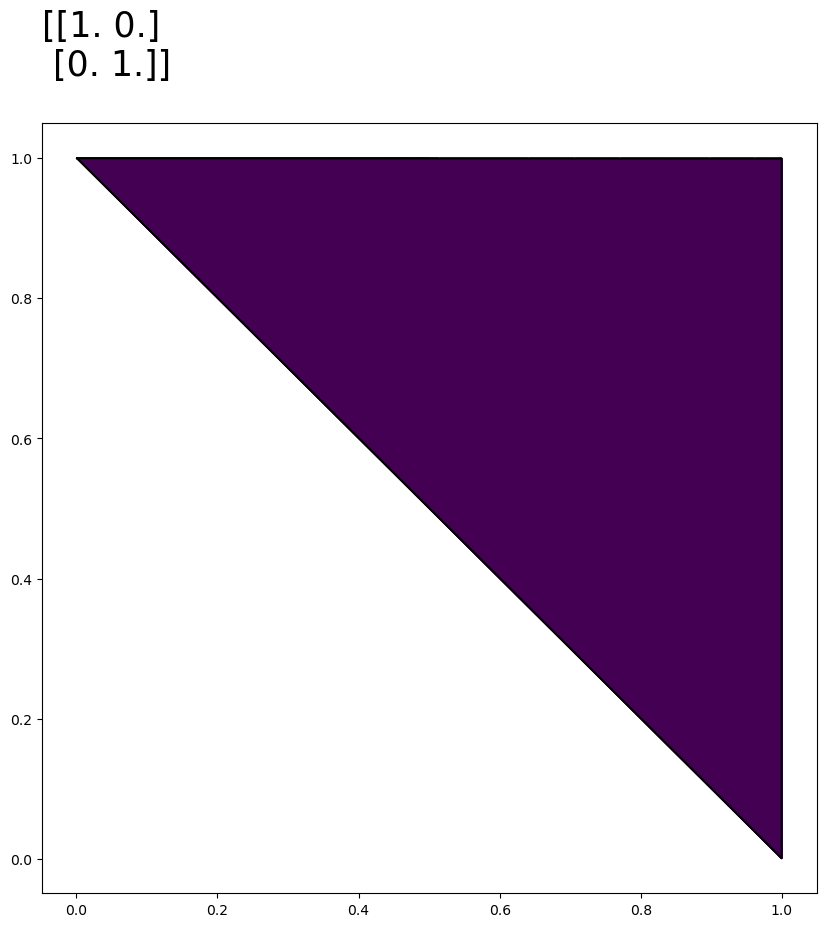

In [15]:
#plot the poincare section for the cusp represenation
plot(df, vecs, c[i][j], j, n_squares, index, test = False)

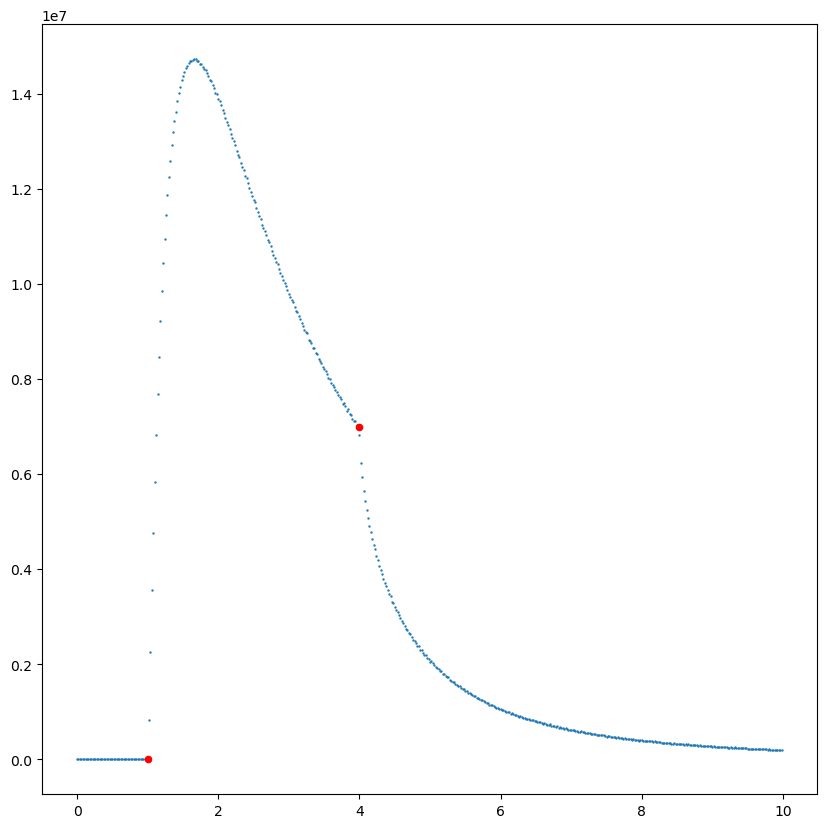

In [16]:
# plot the pdf for this cusp
sec_list = sec_setup(df, dx_y)
secs = sec_comp(sec_list, dx)
times = time_comp(secs)
pdf(list(df["time"]), times, dx*2)
#plt.savefig(os.path.join("results", f"{n_squares} - {index}", f"pdf {j}"))

In [17]:
from scipy import integrate

sum = 0
for i in range(len(secs)):

    all_points = []
    for item in secs[i].points_top:
        all_points.append(item)
    for item in secs[i].points_bottom:
        all_points.append(item)
        
    all_points = set(all_points)
    all_points = list(all_points)
    all_points.sort()
    
    m = 0
    n = 0
    for k in range (1, len(all_points)):
        if (not(all_points[k-1] >= secs[i].points_top[m] and all_points[k] <= secs[i].points_top[m+1])):
            a += 1
        if (not(all_points[k-1] >= secs[i].points_bottom[n] and all_points[k] <= secs[i].points_bottom[n+1])):
            b += 1
        top_eq = secs[i].f_top[m]
        bottom_eq = secs[i].f_bottom[n]
        upper = all_points[k]
        lower = all_points[k-1]
        
        # Perform the double integral
        f = lambda y,x :secs[i].vec[1][0] / (x * (secs[i].vec[0][0] * x + secs[i].vec[1][0] * y))
        result, error = integrate.dblquad(f, lower, upper, lambda x: bottom_eq(x), lambda x: top_eq(x)) 
        sum += result



In [18]:
total += sum
total_list.append(sum)
dfs.append(df)
sum, total

(1.629213036446423, 1.629213036446423)

In [19]:
len(dfs)

1

In [20]:
total_list

[1.629213036446423]

In [13]:
# For an STS, repeatedly run the poincare_details function and get the 
#different representations of cusps and other values and store them in lists
#takes awhile
a = []
c = []
e = []
g = []
for i in range(8):
    try:
        alphas, Cs, C_invs, eigs, Ms, generators, eigenvecs = poincare_details(perm, vecs0)
    except:
        continue
    a.append(alphas)
    c.append(Cs)
    e.append(eigenvecs)
    g.append(generators)

In [25]:
# store these values in case kernel crashes
#%store a
#%store c
#%store e
#%store g

In [21]:
%store total
%store total_list
%store dfs

Stored 'total' (Integer)
Stored 'total_list' (list)
Stored 'dfs' (list)


In [20]:
total = 0
total_list = []
dfs = []